In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# read df
df = pd.read_csv('Data/gold_futures_ohlcv.csv', parse_dates=['ts_event'])
df["ts_event"] = pd.to_datetime(df["ts_event"]).dt.tz_convert('UTC') # ensure it's UTC
df = df.set_index('ts_event', inplace=False)

In [3]:
# filter for vanilla futures contracts
single_contract_filter = (df["symbol"].str.len() == 4)
fdf = df[single_contract_filter].copy()

In [4]:
future_month_map = {
    'F': 1, 'G': 2, 'H': 3, 'J': 4, 'K': 5, 'M': 6,
    'N': 7, 'Q': 8, 'U': 9, 'V': 10, 'X': 11, 'Z': 12
}

In [6]:
# function to determine contract year
def get_contract_year(row):
    contract_year_first_digit = int(row["symbol"][3])
    curr_year = row.name.year
    if contract_year_first_digit < curr_year % 10:
        contract_year = math.ceil(curr_year / 10) * 10 + contract_year_first_digit
    else:
        contract_year = math.floor(curr_year / 10) * 10 + contract_year_first_digit
    return contract_year

fdf["contract_year"] = fdf.apply(get_contract_year, axis=1)
fdf["contract_month"] = fdf.apply(lambda row: future_month_map[row['symbol'][2]], axis=1)

In [8]:
# function to determine expiry length
def get_expiry_length(row):
    month = future_month_map[row['symbol'][2]]
    year = row["contract_year"]
    # Calculate the difference in months
    return (year - row.name.year) * 12 + month - row.name.month

fdf["expiry_length"] = fdf.apply(get_expiry_length, axis=1)

In [9]:
LENGTH = 6
frdf = fdf[fdf['expiry_length'] == LENGTH].copy()
sdf = fdf[fdf['expiry_length'] == (LENGTH + 1)].copy()

In [10]:
frdf.shape, sdf.shape

((2273, 12), (2251, 12))

In [ ]:
def create_continuous_contract(frdf, sdf):
    # Sort both dataframes by date
    frdf = frdf.sort_index()
    sdf = sdf.sort_index()
    
    # Combine both dataframes and sort by date
    combined = pd.concat([frdf, sdf]).sort_index()
    
    # Group by date to find available contracts for each day
    daily_data = combined.groupby(combined.index.date)
    
    # Initialize variables for adjustment
    prev_close = None
    current_symbol = None
    continuous = pd.DataFrame()
    diff_day_adj = 0
    
    # process each day
    for day, group in daily_data:
        # use LENGTH+1 if LENGTH is not available
        if not group[group['expiry_length'] == LENGTH].empty:
            contract = group[group['expiry_length'] == LENGTH].iloc[0]
        else:
            contract = group[group['expiry_length'] == LENGTH + 1].iloc[0]
        
        # calculate adjustment only when switching contracts
        old_contract_exists = not group[group['symbol'] == current_symbol].empty
        different_contract = current_symbol != contract['symbol']

        if current_symbol is not None and different_contract and old_contract_exists:
            # adjustment equals difference in contracts if available
            adjustment = contract['close'] - group.loc[group['symbol'] == current_symbol, 'close'].iloc[0]

        elif current_symbol and different_contract and not old_contract_exists:
            # adjustment equals diffrence in contracts but between a day
            adjustment = contract['close'] - prev_close
            diff_day_adj += 1

        else:
            adjustment = 0
        
        # Store current values for next iteration
        current_symbol = contract['symbol']
        prev_close = contract['close']
        
        # Create adjusted prices
        row = pd.Series({
            'symbol': contract['symbol'],
            'open': contract['open'],
            'high': contract['high'],
            'low': contract['low'],
            'close': contract['close'],
            'volume': contract['volume'],
            'expiry_length': contract['expiry_length'],
            'adjustment': adjustment

        }, name=group.index[0])
        
        continuous = pd.concat([continuous, pd.DataFrame([row])])
    
    print(f'Num of diff day adjustments {diff_day_adj}')
    return continuous


# Create the continuous contract
continuous_contract = create_continuous_contract(frdf, sdf)

2010-07-01
2010-09-01
2010-11-01
2011-01-02
2011-03-01
2011-05-01
2011-07-01
2011-09-01
2011-11-01
2012-01-03
2012-03-01
2012-05-01
2012-07-02
2012-09-02
2012-11-01
2013-01-01
2013-03-01
2013-05-01
2013-07-01
2013-09-02
2013-11-01
2014-01-02
2014-03-02
2014-05-01
2014-07-01
2014-09-02
2014-11-02
2015-01-01
2015-03-02
2015-05-01
2015-07-01
2015-09-01
2015-11-01
2016-01-04
2016-03-01
2016-05-01
2016-07-01
2016-09-01
2016-11-01
2017-01-03
2017-03-01
2017-05-01
2017-07-03
2017-09-01
2017-11-01
2018-01-02
2018-03-01
2018-05-01
2018-07-02
2018-09-03
2018-11-01
2019-01-02
2019-03-01
2019-05-01
2019-07-01
2019-09-01
2019-11-01
2020-01-02
2020-03-02
2020-05-01
2020-07-01
2020-09-01
2020-11-02
2021-01-03
2021-03-01
2021-05-02
2021-07-01
2021-09-01
2021-11-01
2022-01-03
2022-03-01
2022-05-01
2022-07-01
2022-09-01
2022-11-01
2023-01-02
2023-03-01
2023-05-01
2023-07-02
2023-09-01
2023-11-01
2024-01-01
2024-03-01
2024-05-01
2024-07-01
2024-09-01
2024-11-01
2025-01-01
2025-03-02
2025-03-14
2025-03-18

In [27]:
fdf[(fdf['expiry_length'] == LENGTH) | (fdf['expiry_length'] == LENGTH + 1)].tail(40)

,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol,contract_year,contract_month,expiry_length
ts_event,,,,,,,,,,,,
2025-06-26 00:00:00+00:00,35,1,39231,3407.0,3417.3,3378.3,3388.4,727,GCZ5,2025,12,6
2025-06-27 00:00:00+00:00,35,1,39231,3384.0,3388.8,3321.8,3340.0,1537,GCZ5,2025,12,6
2025-06-29 00:00:00+00:00,35,1,39231,3339.7,3345.7,3307.4,3331.2,114,GCZ5,2025,12,6
2025-06-30 00:00:00+00:00,35,1,39231,3332.7,3380.3,3325.3,3376.0,1323,GCZ5,2025,12,6
2025-07-01 00:00:00+00:00,35,1,42028866,3426.4,3426.4,3426.4,3426.4,1,GCF6,2026,1,6
2025-07-01 00:00:00+00:00,35,1,42001025,3413.2,3447.9,3408.6,3432.8,119,GCG6,2026,2,7
2025-07-02 00:00:00+00:00,35,1,42001025,3428.0,3456.3,3421.0,3443.0,158,GCG6,2026,2,7
2025-07-03 00:00:00+00:00,35,1,42001025,3440.7,3451.1,3405.7,3421.6,107,GCG6,2026,2,7
2025-07-04 00:00:00+00:00,35,1,42001025,3426.7,3437.2,3421.1,3425.6,13,GCG6,2026,2,7


In [31]:
sum_adj = np.cumsum(np.array(continuous_contract['adjustment'])[::-1])[::-1]
adj = continuous_contract[['open', 'high', 'low', 'close']].add(sum_adj, axis=0)

<Axes: >

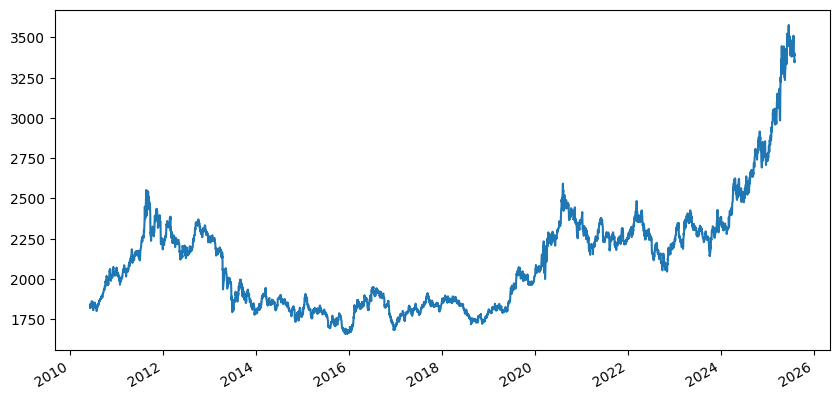

In [36]:
adj['close'].plot(figsize=(10,5))